Power Method
-------------

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#import sklearn.datasets as skdata
from scipy.stats import ortho_group
from numpy import linalg as LA
import os


In [31]:

def power_step(A, w0):
    """Computes one step in power method to compute an approximation for dominant
    eigenpair of A"""
    w = A@w0
    norm = LA.norm(w)
    w = w/norm
    mu = w.T@A@w
    return mu, w

def power_method(A, n_iterations: int):
    """A slightly modified version of
    the function power_iteration retrieved from 
    https://en.wikipedia.org/wiki/Power_iteration
    (Retrieved: 8.9.2022)
    Function computes n_iterations of power_method 
    and returns the dominant eigenpair of each step"""

    dimA = A.shape[1]

    #initialize
    W_T = np.zeros((n_iterations, dimA))
    mus = np.zeros(n_iterations)
    w0 = np.random.rand(dimA)
    norm = LA.norm(w0)
    #normalize
    w0 = w0 / norm


    #assign values in row order bc numpy row major
    for i in np.arange(n_iterations):
        mui, wi = power_step(A, w0)
        mus[i] = mui
        W_T[i,:] = wi
        w0 = wi
 
    return mus, W_T


def hotelling(A, v, mu, n_iterations):
    """Function to compute the second eigenvector after the largest
    eigenvalue and corresponding eigenvector has been computed.
    Function utilizes Hotelling's method.
    Parameters:
    A : 2D array
    v : 1D array. Approximated eigenvector corresponding to the approximated largest eigenvalue of A. 
    a : float. Approximation of largest eigenvalue of A.
    n_iterations : int"""

    dimA = A.shape[1]
    W_T = np.zeros((n_iterations, dimA))
    mus = np.zeros(n_iterations)
    w0 = np.random.rand(dimA)
    norm = LA.norm(w0)
    #normalize
    w0 = w0 / norm

    for i in np.arange(n_iterations):
        wi = A@w0-mu*(v.T@w0)*v
        norm = LA.norm(wi)
        #normalize
        wi = wi / norm
        mui = wi.T@A@wi
        mus[i] = mui
        W_T[i,:] = wi
        w0 = wi
        

    return mus, W_T




def err_mus(mu_exact, mu_approxs):
    exacts = np.repeat(mu_exact, len(mu_approxs))
    return abs(exacts-mu_approxs)

def err_w(w_approx, w_exact):
    """Helper 1-D function to map with err_ws. Note the order of parameters."""
    err = min(LA.norm(w_exact-w_approx), LA.norm(-w_exact-w_approx)) #could converge to -x1 which also eigvec
    return err



def err_WT(w_exact, WT):
    err_WT = np.apply_along_axis(err_w, 1, WT, w_exact=w_exact)
    return err_WT


def create_dataset(mu1s, mu2s, err_mu1s, err_mu2s, err_WT1s, err_WT2s, matrix_dim, eigengap):
    out = xr.Dataset(
        data_vars={"mu1s": (["run", "iteration"], mu1s),
                   "mu2s": (["run", "iteration"], mu2s),
                    "err_mu1s": (["run", "iteration"], err_mu1s),
                   "err_mu2s": (["run", "iteration"], err_mu2s),
                   "err_WT1s": (["run", "iteration"], err_WT1s),
                   "err_WT2s": (["run", "iteration"], err_WT2s)},
        attrs={'comment': f"Absolute errors in {err_mu1s.shape[0]} runs of power method with matrix dimension {matrix_dim}, and eigengaps {eigengap}"}
    )
    return out


Random matrices for numerical examples
--------------------------------------

In [3]:



def create_QDQT(n:int, eigs:list):
    Q = ortho_group.rvs(n)
    D = np.diag(eigs)
    return Q@D@Q.T

In [35]:
n = 100 # matrix dimension

#predefined eigenvalues
eigengap = 0.05 #gap between lambda_1 and lambda_2 & lambda_2 & others


top2 =  [1.0, 1.0-eigengap]
others = 1.0-eigengap*2



eigs = np.repeat(others, n)
eigs[0:2] = top2
print(eigs)


K = 100 #how many iterations for power_method
n_runs = 1000 #how many runs with different matrix with similar eigenstructure




mu1s = np.zeros([n_runs, K])
mu2s = np.zeros([n_runs, K])
err_mu1s = np.zeros([n_runs, K])
err_mu2s = np.zeros([n_runs, K])
err_WT1s = np.zeros([n_runs, K])
err_WT2s = np.zeros([n_runs, K])


for i in np.arange(n_runs):

    
    #generate new random matrix with similar eigenstructure
    M = create_QDQT(n, eigs)

    #exact eigenvals and eigenvecs
    evals, evecs = LA.eigh(M)
    lam1 = evals[-1]
    lam2 = evals[-2]
    x1 = evecs[:,-1]
    x2 = evecs[:,-2]

    mu1s_i, WT1_i = power_method(M, K)
    mu2s_i, WT2_i = hotelling(M, WT1_i[-1], mu1s_i[-1], K)

    #absolute errors of run i
    err_mu1s_i = err_mus(lam1, mu1s_i)
    err_mu2s_i = err_mus(lam2, mu2s_i)

    err_WT1_i = err_WT(x1, WT1_i)
    err_WT2_i = err_WT(x2, WT2_i)


    #assemble into arrays with row i = run i of power method, col j = jth iteration
    mu1s[i,:] = mu1s_i
    mu2s[i,:] = mu2s_i


    err_mu1s[i, :] = err_mu1s_i
    err_mu2s[i, :] = err_mu2s_i

    err_WT1s[i, :] = err_WT1_i
    err_WT2s[i, :] = err_WT2_i

#save as netCDF
OUTPUT_PATH = '/home/pietaril/Documents/data/powermethod_data/'
output_filename = f"powerset_eigengap_{eigengap}.nc"
out = create_dataset(mu1s, mu2s, err_mu1s, err_mu2s, err_WT1s, err_WT2s, n, eigengap)
out.to_netcdf(os.path.join(OUTPUT_PATH, output_filename))
    





[1.   0.95 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9 ]


In [11]:
A = np.ones((2,2))
A[1,:] = 2
A

array([[1., 1.],
       [2., 2.]])

In [14]:
np.mean(A, 0)

array([1.5, 1.5])

In [3]:
def get_stats(DATAPATH, eiggap):
    """Get statistics of power method runs for each iteration"""

    ds = xr.open_dataset(f"{DATAPATH}powerset_eigengap_{eiggap}.nc")
    stats = {}
    for key in ["err_mu1s", "err_mu2s", "err_WT1s", "err_WT2s"]:
        errs = ds[key].values
        stats[key] = [np.min(errs, 0), np.mean(errs,0), np.max(errs,0)]
    return stats

DATAPATH = '/home/pietaril/Documents/data/powermethod_data/'

da1_stats = get_stats(DATAPATH, 0.2)
da2_stats = get_stats(DATAPATH, 0.1)
da3_stats = get_stats(DATAPATH, 0.05)


In [50]:
aaaa= da2_stats["err_mu1s"][0]

np.vstack((aaaa, aaaa)).shape

(2, 100)

Looks like it's maybe better to have separate plots for eigenval & eigenvec errors since scales differ a lot

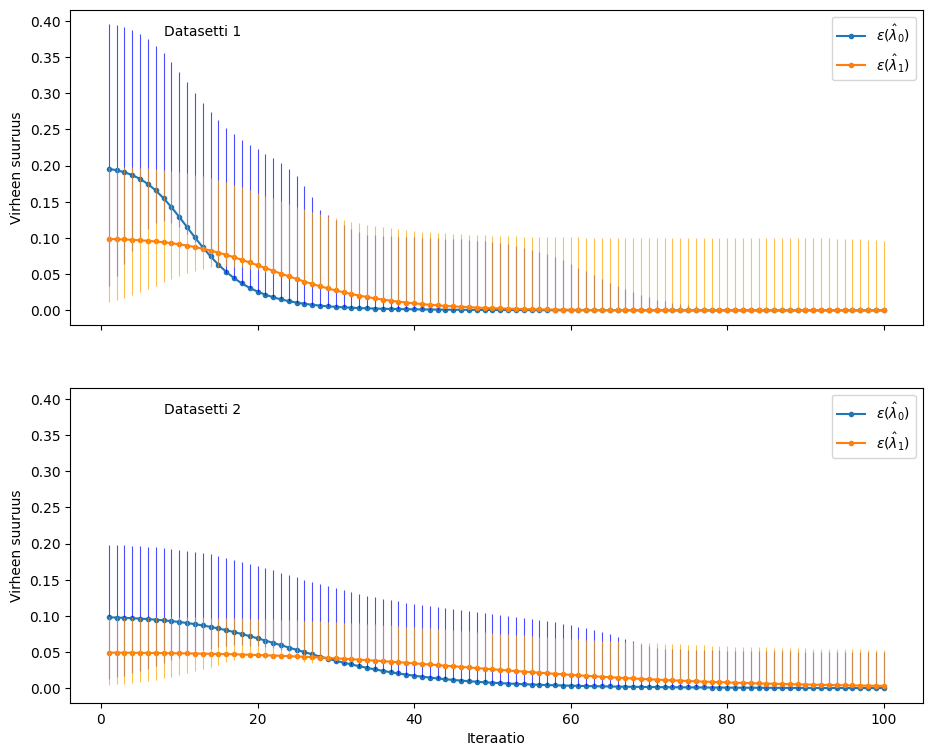

In [19]:
import matplotlib.pyplot as plt

#eigenvalue convergence
K = 100


data =  [da2_stats, da3_stats]

colors = ["blue", "orange"]
keys =  ["err_mu1s", "err_mu2s"]

fig, axs = plt.subplots(2,1, figsize = (11,9), sharey = True)
for i in range(2):
    da = data[i]
    axs[i].set_ylabel("Virheen suuruus")
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \epsilon ( \hat \lambda_{j} ) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 0.8)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend()
        #axs[i].set_yscale('log')
    axs[i].text(8, 0.38, f"Datasetti {i+1}")
axs[1].set_xlabel("Iteraatio")
axs[0].set_xticklabels([])
fig.suptitle("")

    
plt.show()

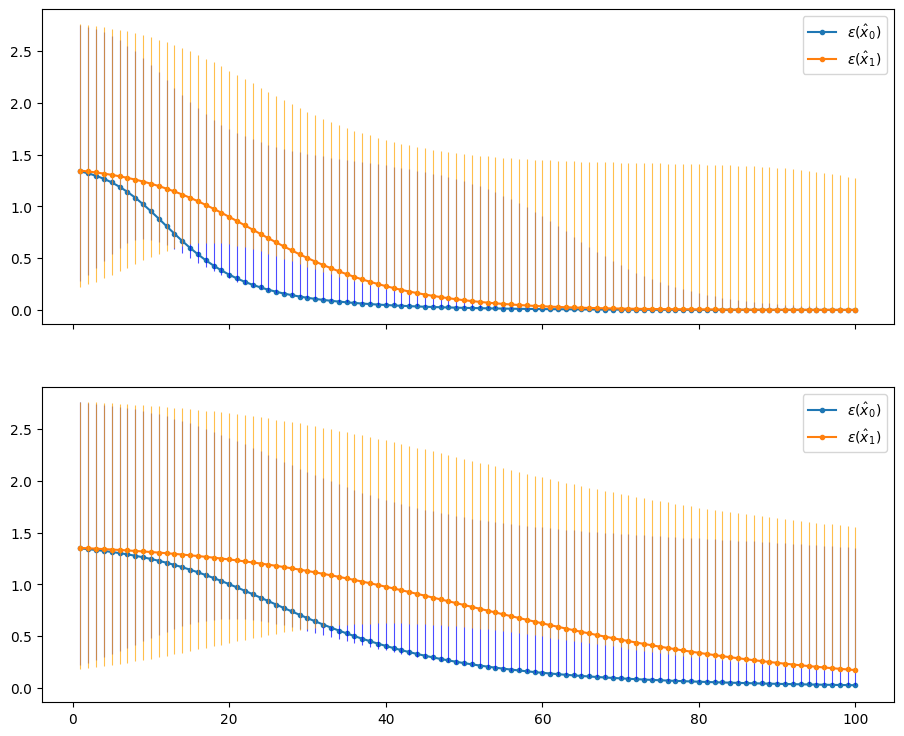

In [10]:
#eigenvector convergence


keys = ["err_WT1s", "err_WT2s"]

fig, axs = plt.subplots(2,1, figsize = (11,9), sharey = True, sharex = True)
for i in range(2):
    da = data[i]
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \epsilon ( \hat x_{j} ) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 0.8)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend()
        #axs[i].set_yscale('log')
plt.show()

NameError: name 'n_runs' is not defined

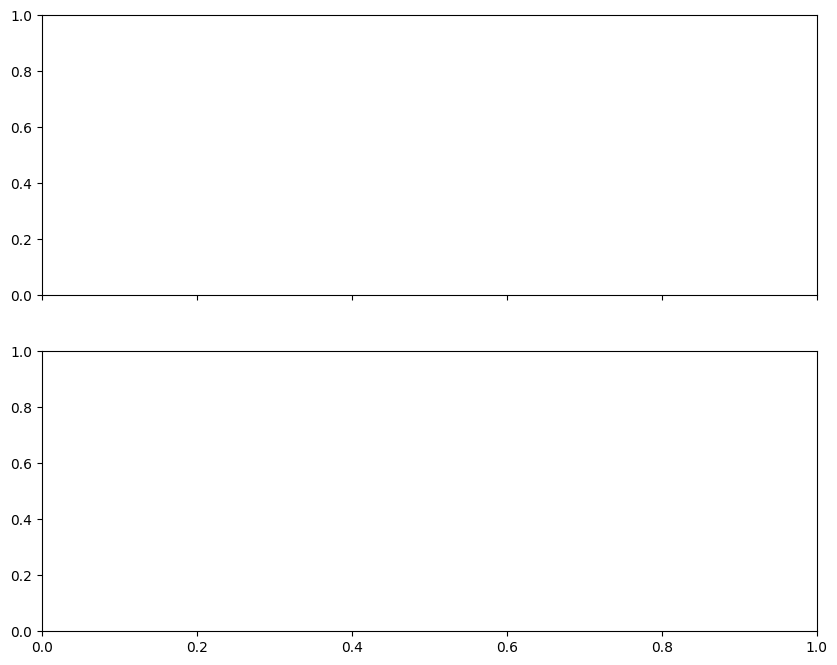

In [9]:

import matplotlib.pyplot as plt

errs_w = ["err_WT1s", "err_WT2s"]

fig, axs = plt.subplots(2,1, figsize = (10,8), sharex='col')
for i in range(2):
    for j in range(n_runs):
        axs[i].plot(np.arange(1, K+1), errs_w[i][j][:], marker = '.', linewidth = 0.8, markersize = 1.2)
    axs[i].set_ylabel(f"$\epsilon_{i+1}$")
    #axs[i].set_yscale('log')

axs[1].set_xlabel("Iteraatio")
fig.suptitle(f"Potenssimenetelmän konvergoituminen")
plt.tight_layout
plt.show()

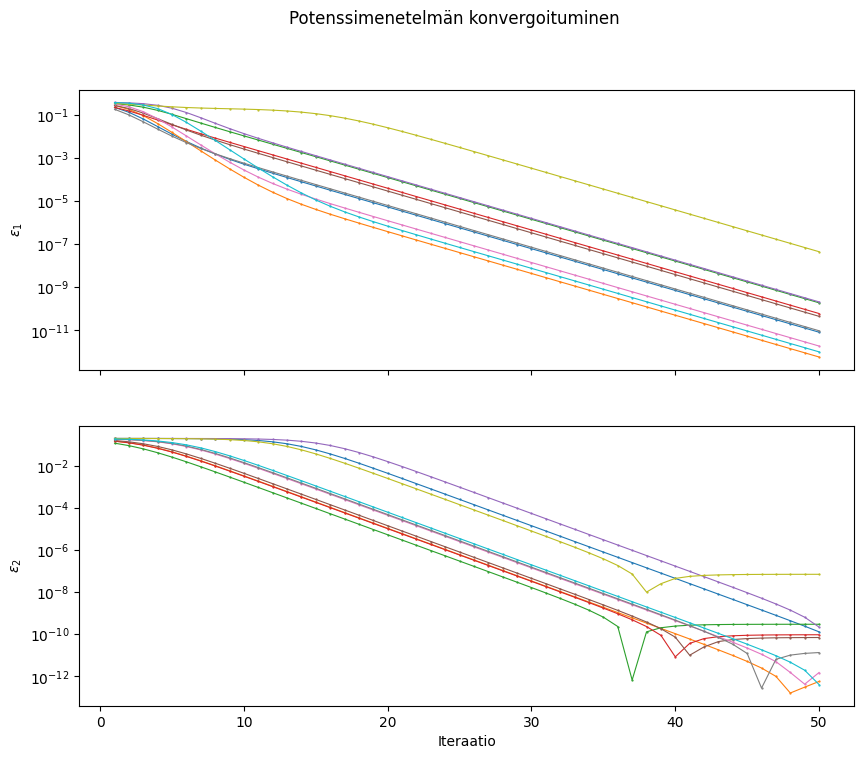

In [16]:



errs_mu = [err_mu1s, err_mu2s]

fig, axs = plt.subplots(2,1, figsize = (10,8), sharex='col')
for i in range(2):
    for j in range(n_runs):
        axs[i].plot(np.arange(1, K+1), errs_mu[i][j][:], marker = '.', linewidth = 0.8, markersize = 1.2)
    axs[i].set_ylabel(f"$\epsilon_{i+1}$")
    axs[i].set_yscale('log')
axs[1].set_xlabel("Iteraatio")


fig.suptitle(f"Potenssimenetelmän konvergoituminen")
plt.tight_layout
plt.show()

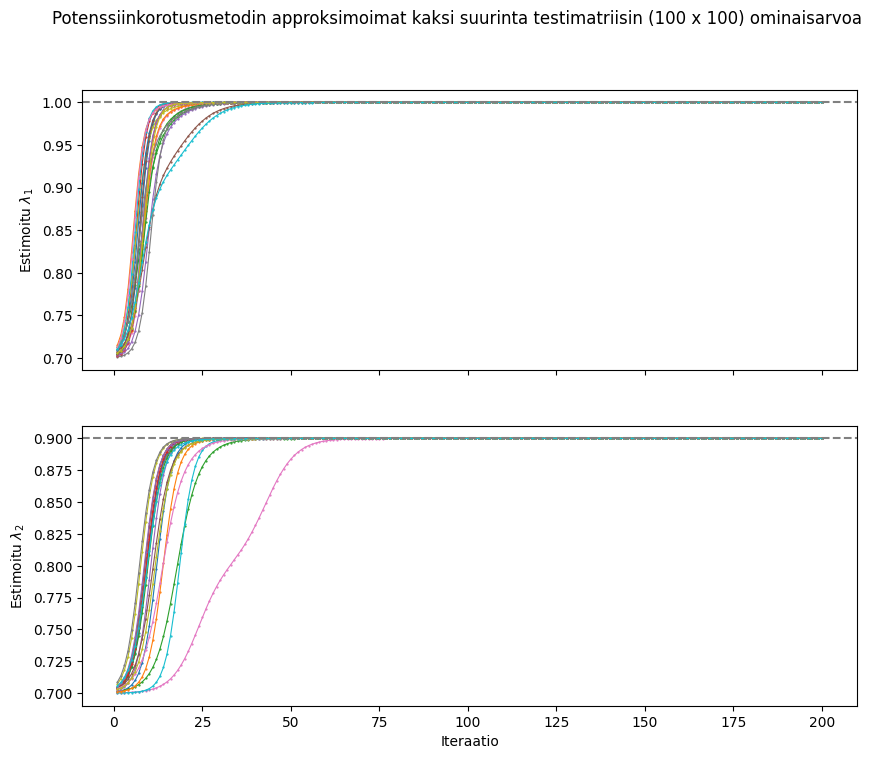

In [46]:




import matplotlib.pyplot as plt
labels = [r'$\lambda_1$', r'$\lambda_2$']

mus = [mu1s, mu2s]

fig, axs = plt.subplots(2,1, figsize = (10,8), sharex='col')
for i in range(2):
    for j in range(n_runs):
        axs[i].plot(np.arange(1, K+1), mus[i][j][:], marker = '.', linewidth = 0.8, markersize = 1.2)
    axs[i].axhline(y=evals[-(i+1)], linestyle = 'dashed', color = 'grey')
    axs[i].set_ylabel(f"Estimoitu {labels[i]}")
axs[1].set_xlabel("Iteraatio")
#axs[1].set_xticks(np.arange(1, K+1))
fig.suptitle(f"Potenssiinkorotusmetodin approksimoimat kaksi suurinta testimatriisin ({n} x {n}) ominaisarvoa")
plt.tight_layout
plt.show()

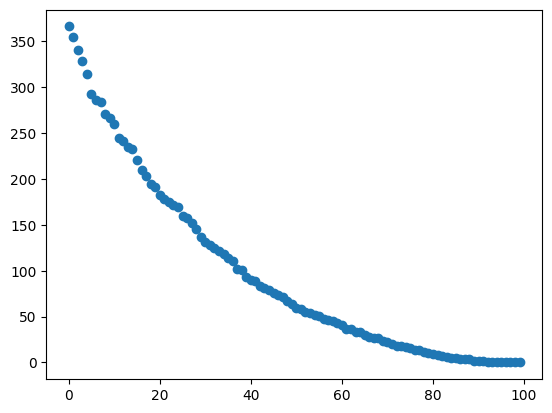

In [62]:
fig, ax = plt.subplots()
ax.scatter(np.arange(n), evals[::-1])
plt.show()

In [18]:
mus, vs, errs = power_method_thresh(M, 1e-5, maxiter=1000)


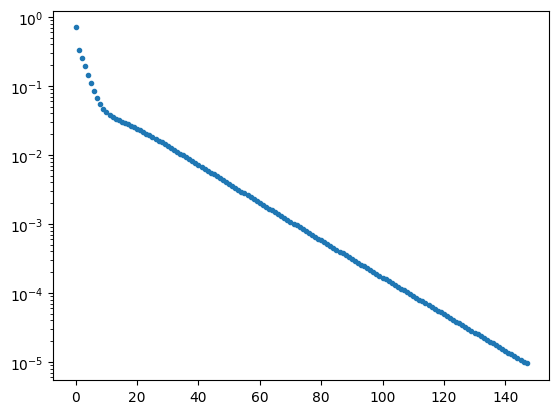

In [21]:
fig, ax = plt.subplots()
#ax.semilogy(np.arange(len(errs)), errs, marker = '.')
ax.scatter(np.arange(len(errs)), errs, marker = '.')
ax.set_yscale('log')

Quick checks how the rows and columns work with different commands

In [51]:

u = np.ones(5)
w = np.ones(5)*2
u_T = np.array([u])
uw_T = np.row_stack((u,w))
uw = np.column_stack((u,w))
print(uw)
print(uw_T)
print(uw_T.dot(uw))


uw.shape

[[1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]]
[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]]
[[ 5. 10.]
 [10. 20.]]


(5, 2)

Truncated SVD
--------------

Implementing truncated SVD as an estimate of the matrix inverse

The version with reduced dimensions in V and D

In [159]:
#Number of largest eigenvalues to include
r = 3000
#evals in descending order
t_evals = evals[::-1].copy()
#take only the first r evals
t_evals = t_evals[:r]
#replace the remaining eigenvalues with their reciprocal
t_evals = 1/t_evals
#evecs to the same order as evals
t_evecs = np.fliplr(evecs.copy())
#take only the first r evecs
t_evecs = t_evecs[:,:r]





Version with full dimensions in V and D, and the "discarded" vectors and eigenvalues set to zero

In [134]:
#Number of largest eigenvalues to include
r = 200
#evals in descending order
t_evals = evals[::-1].copy()
#set all but the r largest evals to zero
t_evals[r:] = 0
#replace the r largest eigenvalues with their reciprocal
t_evals[:r] = 1/t_evals[:r]
#evecs in the same order as evals
t_evecs = np.fliplr(evecs.copy())
#set all but the r first eigvecs to zero vectors
t_evecs[:,r:] = 0

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [131]:
act_invM = LA.inv(M)

In [160]:
Mtsvd = t_evecs.dot(np.diag(t_evals)).dot(t_evecs.T) 

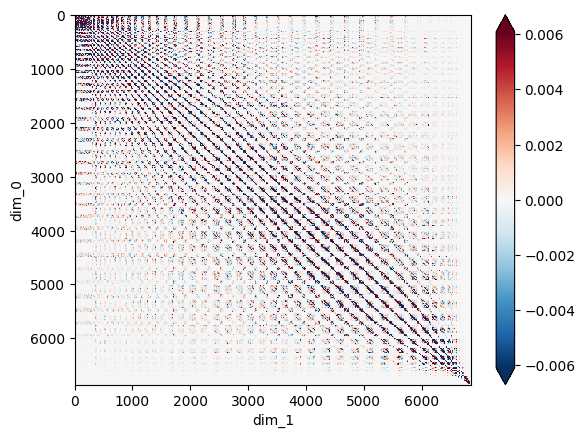

In [161]:
Mtsvd = xr.DataArray(Mtsvd)
fig, ax = plt.subplots()
Mtsvd.plot.imshow(yincrease = False, robust = True)
plt.show()

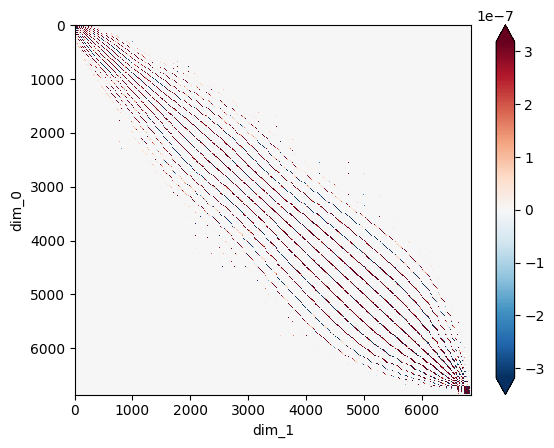

In [137]:
act_invM = xr.DataArray(act_invM)
fig, ax = plt.subplots()
act_invM.plot.imshow(yincrease = False, robust = True)
plt.show()

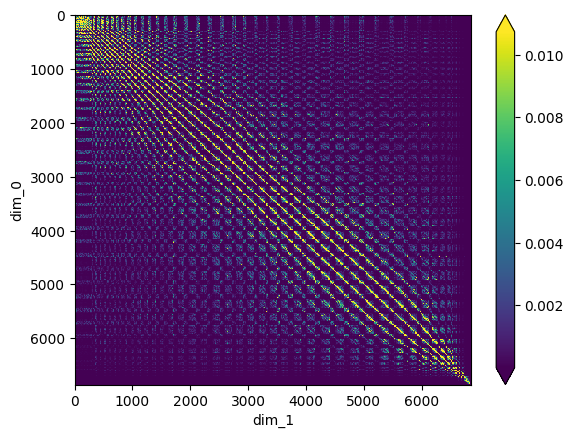

In [162]:
M_diff = xr.DataArray(abs(act_invM-Mtsvd))
ig, ax = plt.subplots()
M_diff.plot.imshow(yincrease = False, robust = True)
plt.show()


Testing the convergence of the eigenvalue estimates
---------------------------------------------------

In [7]:

print(evals[range(-1,-500,-1)])



[15.15454765 11.69482561 10.32612078  9.96130532  9.89193315  9.75719582
  9.24783414  9.15443245  8.89805937  8.89677888  8.70833449  8.57827471
  8.480616    8.442306    8.37016884  8.20974608  8.16437133  8.12131873
  7.97676669  7.93956906  7.82334086  7.81316668  7.66265984  7.58205222
  7.50829735  7.48964067  7.33508437  7.26973259  7.26901381  7.21151976
  7.18736552  7.1623497   7.12815879  7.00966882  7.0044297   6.93104487
  6.88485598  6.8072074   6.78371445  6.73600985  6.69717811  6.65563704
  6.62729434  6.55959354  6.54931686  6.53780389  6.46489517  6.45807605
  6.37861479  6.3361404   6.33305796  6.33159464  6.30818108  6.29554585
  6.27008196  6.22122141  6.2076039   6.19458915  6.0942128   6.07730724
  6.06229881  6.04101702  6.02316135  5.98209365  5.95785506  5.94728766
  5.90496726  5.88136927  5.83020675  5.82703167  5.80729998  5.77127834
  5.75486824  5.73679809  5.71804387  5.67364378  5.65498058  5.63677967
  5.61045504  5.59369332  5.56463454  5.55684648  5

[[41.69398988 40.68340295 29.03596293]
 [59.19740884 36.55905608 53.77347525]
 [56.35415908 60.30786493 46.8153088 ]
 [60.87062338 58.2856431  40.46719661]
 [60.43204611 58.63371482 35.56816026]
 [60.9048315  57.49995779 44.7535011 ]
 [61.34293908 59.86549126 40.43935396]
 [61.4802906  59.78115983 40.79964355]
 [61.18213039 60.01725471 40.49257547]
 [61.07824574 57.51974078 37.74388108]
 [60.12012747 61.20164293 40.6274037 ]
 [61.10746712 60.21686274 40.21180584]
 [61.7524622  59.38667144 40.98070048]
 [61.28019846 60.00992505 40.89802346]
 [59.74060005 61.56375597 40.83990771]]


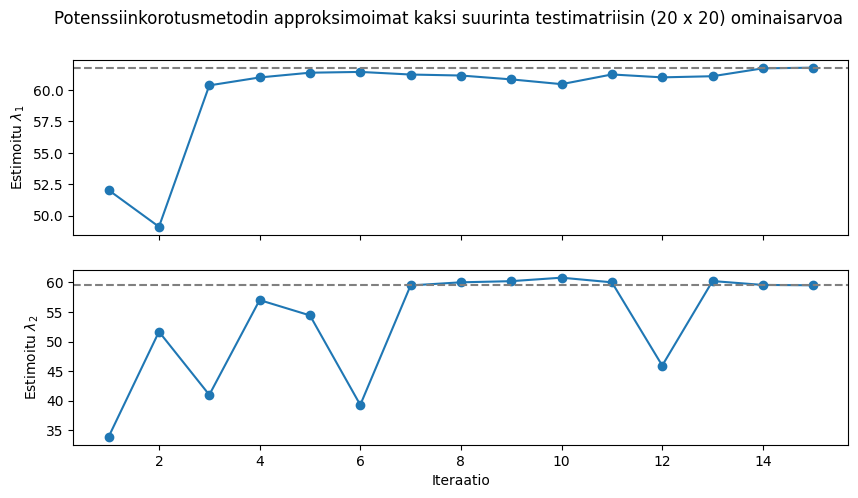

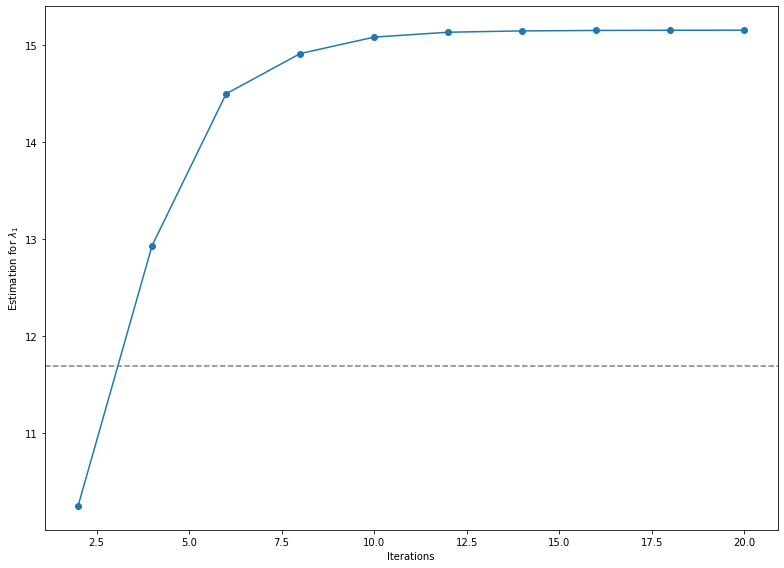

In [36]:
fig, ax = plt.subplots(figsize = (11,8), layout = 'tight', sharex='row')
ax.plot(iterations, power_evals[:,0], marker = 'o')
ax.axhline(y=evals[-(i+1)], linestyle = 'dashed', color = 'grey')
ax.set_ylabel(f"Estimation for {labels[0]}")
ax.set_xlabel("Iterations")
plt.show()

In [75]:
largest_evecs = evecs[range(-1,-11,-1)]
residuals = []
diffs = []
for i in range(10):
    residual = residual_norm(M, V_T[i], mu_s[i])
    residuals.append(residual)
    diff = LA.norm(largest_evecs[i]-V_T[i])
    diffs.append(diff)
print(residuals)
print(diffs)




[3.4060245772776416e-11, 3.618968745565533e-06, 0.009194577471923478, 0.024766905747349317, 0.02288058312727909, 0.04620733890848414, 0.0492595791563369, 0.0848178556572693, 0.0868597470467658, 0.12367572420895566]
[1.4142135623730951, 1.4142135623730945, 1.4142135623717602, 1.4142135622969043, 1.4142135623339784, 1.4142135586715225, 1.414213514188876, 1.414213525606388, 1.4142134352976992, 1.414213321693363]


In [67]:
eval1/eval2

1.295833572422536

In [58]:
print(largest_evecs[0])
print(V_T[0])

[0. 0. 0. ... 0. 0. 0.]
[1.02238389e-17 3.17420128e-17 4.43083516e-17 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [18]:

# check if the real and approximated eigenvector linearly dependent
A = np.stack((v_2, evec2), axis=1)
LA.matrix_rank(A)



2

11.694825610284667


In [7]:
for i in np.arange(len(evec1)):
    x = evec1[i]
    if x != 0.0:
        print(i,x)

11 1.0


In [51]:
for i in range(50,400,50):
    v_2 = hotelling2(M, v, a, i)
    a_2 = rayleigh_quotient(M, v_2)
    norm = residual_norm(M, v_2, a_2)
    print(f"Iteration {i}, residual norm: {norm}")
    

Iteration 50, residual norm: 0.002694597137400284
Iteration 100, residual norm: 0.00023027591081764133
Iteration 150, residual norm: 6.717010804712341e-05
Iteration 200, residual norm: 0.00014071462095937545
Iteration 250, residual norm: 0.00015732072384204554
Iteration 300, residual norm: 0.00018789944059598136
Iteration 350, residual norm: 1.0853296793970103e-06


In [49]:
#print(f"Real eigval: {eval1}")


for i in range(100,1000, 100):
    v = power_iteration(M, i)
    a = rayleigh_quotient(M, v)
    norm = residual_norm(M, v, a)
    print(f"Iteration: {i}, residual norm: {norm}")
    #print(f"Iteration: {i}, estimated eigval: {a}, residual norm: {norm}")
    
    

Iteration: 100, residual norm: 1.0367997085054587e-07
Iteration: 200, residual norm: 2.0375336947625995e-13
Iteration: 300, residual norm: 5.551169297415832e-17
Iteration: 400, residual norm: 5.551157474611588e-17
Iteration: 500, residual norm: 5.551157474611588e-17
Iteration: 600, residual norm: 5.551157474611588e-17
Iteration: 700, residual norm: 5.551157474611588e-17
Iteration: 800, residual norm: 5.551157474611588e-17
Iteration: 900, residual norm: 5.551157474611588e-17
